# Third model, first analysis

This is our third pass at getting a model that includes all the volumes we need. It adds about 40 volumes in a British canon (nonusnorton), and more importantly does some manual correction of metadata in order to generate "contrast sets" that are dated as accurately as our hypothesis sets.

However, I don't expect results to change very much from the second model.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, math, random
from scipy.stats import pearsonr, zscore, ttest_ind
from statistics import mean, stdev
from math import sqrt

### get metadata

In order to analyze the data we will need a metadata table that includes information about volumes, including inferred biographical information about the author (age, gender, nationality) and columns that assign volumes to particular "hypothesis" and "contrast" sets.

In [36]:
meta = pd.read_csv('../supplement3/thirdmastermeta.tsv', sep = '\t', index_col = 'docid')
print(meta.shape)
meta.columns

(39784, 39)


Index(['allcopiesofwork', 'author', 'copiesin25yrs', 'earlyedition', 'imprint',
       'inferreddate', 'lastname', 'latestcomp', 'nationality', 'isusa',
       'actualgender', 'likelygender', 'title', 'authordate', 'birth', 'age',
       'recordid', 'best1821_1900', 'best1900_1950', 'best1950_1990',
       'anybest', 'best1821_1900contrast', 'best1900_1950contrast',
       'best1950_1990contrast', 'reviewed1850_1950',
       'reviewed1850_1950contrast', 'heath', 'heathcontrast', 'mostdiscussed',
       'mostdiscussedcontrast', 'usnorton', 'usnortoncontrast', 'nonusnorton',
       'nonusnortoncontrast', 'preregistered', 'preregisteredcontrast',
       'reviewed1965_1990', 'reviewed1965_1990contrast', 'toremove'],
      dtype='object')

### get data

Now the data itself. This is broken into a number of "summary files" because the processing that produced it had to be distributed across a cluster. (The entropy calculation is done by comparing individual volumes to each other, and when you've got 40k vols, the number of cross-comparisons becomes fairly large.)

So we first make a list of all the files we need ...

In [3]:
paths = glob.glob('../supp3results/*summary.tsv')
paths

['../supp3results/supp3_12000summary.tsv',
 '../supp3results/supp3_38000summary.tsv',
 '../supp3results/supp3_16000summary.tsv',
 '../supp3results/supp3_0summary.tsv',
 '../supp3results/supp3_8000summary.tsv',
 '../supp3results/supp3_28000summary.tsv',
 '../supp3results/supp3_26000summary.tsv',
 '../supp3results/supp3_22000summary.tsv',
 '../supp3results/supp3_2000summary.tsv',
 '../supp3results/supp3_6000summary.tsv',
 '../supp3results/supp3_32000summary.tsv',
 '../supp3results/supp3_36000summary.tsv',
 '../supp3results/supp3_18000summary.tsv',
 '../supp3results/supp3_20000summary.tsv',
 '../supp3results/supp3_24000summary.tsv',
 '../supp3results/supp3_34000summary.tsv',
 '../supp3results/supp3_30000summary.tsv',
 '../supp3results/supp3_4000summary.tsv',
 '../supp3results/supp3_14000summary.tsv',
 '../supp3results/supp3_10000summary.tsv']

... and then loop across the list, reading them in ... and finally concatenate the data frames.

In [4]:
dfs = []
for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)

data = pd.concat(dfs, verify_integrity = True)
print(data.shape)

(39784, 27)


Thank god, the number of rows in metadata == number of rows in data!

### test hypotheses on raw data

There are lots of ways we can test our hypotheses, but first let's start simple. We'll just identify volumes in the hypothesis set, and those in a contrast set (matched as closely as practical to the hypothesis set in genre, nationality, and date). The [matching strategy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/) is a way of addressing confounding variables without some of the slipperiness of a complex regression.

Then we run a t test on resonance for each of these categories. 

I'm primarily going to measure resonance at the 25-year window, and use all the volumes. I consider the column ```resonance_1.0_25``` the most reliable, generalized test. But I will also test at the 5% level, to see how that differs.

In [43]:
def testahypothesis(hypothesis_cat, data, meta):
    contrast_cat = hypothesis_cat + 'contrast'
    
    hypodocs = meta.index[meta[hypothesis_cat] == 1].tolist()
    contradocs = meta.index[meta[contrast_cat] == 1].tolist()
    
    testoverlap = set(hypodocs).intersection(set(contradocs))
    print(len(testoverlap))
    
    columns = ['resonance_1.0_25', 'resonance_0.05_25']
    
    for col in columns:
        hypothesis_data = data.loc[hypodocs, col]
        hypothesis_data = hypothesis_data[~np.isnan(hypothesis_data)]
        
        contrast_data = data.loc[contradocs, col]
        contrast_data = contrast_data[~np.isnan(contrast_data)]
        
        t, p = ttest_ind(hypothesis_data, contrast_data)
        print(col, "t-test", t, p)
        a = hypothesis_data
        b = contrast_data
        cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
        print(col, "Cohen's d", cohens_d)
        print() 

In [44]:
cols2check = ['best1821_1900',
       'best1900_1950', 'best1950_1990', 'reviewed1850_1950', 'heath', 
        'mostdiscussed', 'usnorton', 'nonusnorton', 'preregistered',
       'reviewed1965_1990']

for col in cols2check:
    print(col)
    testahypothesis(col, data, meta)
    print()

best1821_1900
1
resonance_1.0_25 t-test 4.18207502217 3.90826157017e-05
resonance_1.0_25 Cohen's d 0.507151089725551

resonance_0.05_25 t-test 4.87986587255 1.81742839832e-06
resonance_0.05_25 Cohen's d 0.5917706597464294


best1900_1950
0
resonance_1.0_25 t-test 2.51399280017 0.0124984220009
resonance_1.0_25 Cohen's d 0.29941218533573655

resonance_0.05_25 t-test 1.97802429527 0.0489061447334
resonance_0.05_25 Cohen's d 0.23557926532491685


best1950_1990
0
resonance_1.0_25 t-test -1.05483724148 0.292564931885
resonance_1.0_25 Cohen's d -0.13592742178518313

resonance_0.05_25 t-test -1.79659252091 0.0736630212982
resonance_0.05_25 Cohen's d -0.2313211297690837


reviewed1850_1950
0
resonance_1.0_25 t-test 6.07823498208 1.65383650847e-09
resonance_1.0_25 Cohen's d 0.3609528297449262

resonance_0.05_25 t-test 7.28942164376 5.79881532588e-13
resonance_0.05_25 Cohen's d 0.4316225323709787


heath
0
resonance_1.0_25 t-test 0.697160189666 0.487627577336
resonance_1.0_25 Cohen's d 0.15019955

### analysis

Everything above makes sense.

1. Clear significant positive effects: reviewed books both 1850-1950 and 1965-1990. Our preregistered 20 vols, also the non-US Norton vols. Bestsellers *until* 1950.

2. Heath, usnorton, and mostdiscussed are not significant effects. For all of those groups, n is pretty small. On the other hand, nonusnorton and preregistered are significant with a sample size that's no larger, so the negative result here seems meaningful.

3. The declining significance of bestsellerdom is pretty clear.

There's also one error in there: the "1" instead of a "0" in best1821_1900 suggests that we have a tiny overlap between the hypothesis and contrast set. That shouldn't happen. I will set about fixing.

### interaction with age

The author's age at time of composition / publication is a very powerful factor in this dataset. It's worth considering how it interacts with other categories.

In [45]:
# join age to the data 

data = data.join(meta.age, how = 'inner')
data.shape

(39784, 28)

In [48]:
reviewed_docs = meta.index[meta.reviewed1850_1950 == 1].tolist()
unreviewed_docs = meta.index[meta.reviewed1850_1950contrast == 1].tolist()

reviewed_df = data.loc[reviewed_docs, ['resonance_1.0_25', 'age']]
unreviewed_df = data.loc[unreviewed_docs, ['resonance_1.0_25', 'age']]

In [59]:
plt.rcParams["figure.figsize"] = [10,8]

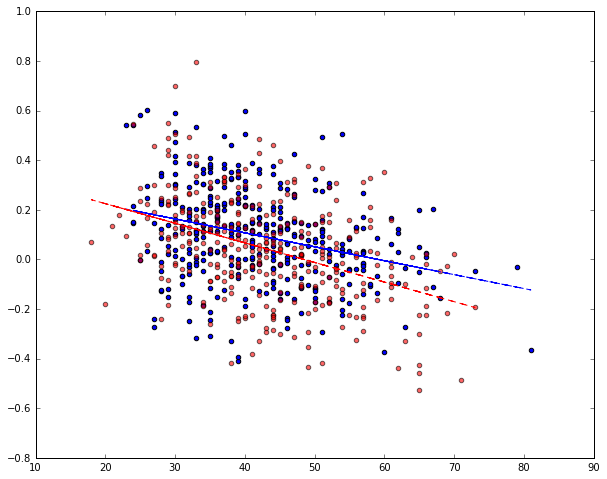

In [63]:
x = reviewed_df.age
y = reviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'b')
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")

x = unreviewed_df.age
y = unreviewed_df['resonance_1.0_25']
plt.scatter(x, y, c = 'r', alpha = 0.6)
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

The lines are pretty much the same around age 20, but they have different slopes. It appears reviewed authors don't lose resonance as quickly as they age. The mean ages in the two datasets are only slightly different:

In [66]:
np.nanmean(reviewed_df.age)

42.038997214484681

In [67]:
np.nanmean(unreviewed_df.age)

42.991044776119402

But the mean resonance is significantly different.

In [68]:
print(np.nanmean(reviewed_df['resonance_1.0_25']))
print(np.nanmean(unreviewed_df['resonance_1.0_25']))

0.0910516897342
0.019892420356
